# Battle of Neighborhoods

We start the notebook by importing and installing some libraries.

In [2]:
import pandas as pd
import numpy as np
!conda install beautifulsoup4 --yes
!conda install requests --yes
!conda install -c conda-forge folium --yes
from bs4 import BeautifulSoup
import requests
import folium
!conda install -c anaconda scikit-learn --yes
print("Libraries installed and imported")

Solving environment: done

## Package Plan ##

  environment location: /home/vininim/anaconda3

  added / updated specs:
    - beautifulsoup4


The following packages will be SUPERSEDED by a higher-priority channel:

  conda              conda-forge::conda-4.9.2-py37h89c1867~ --> pkgs/main::conda-4.9.2-py37h06a4308_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

# All requested packages already installed.

Solving environment: done

## Package Plan ##

  environment location: /home/vininim/anaconda3

  added / updated specs:
    - folium


The following packages will be SUPERSEDED by a higher-priority channel:

  conda               pkgs/main::conda-4.9.2-py37h06a4308_0 --> conda-forge::conda-4.9.2-py37h89c1867_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

# All requested packages already installed.

Libraries installed and imported


We scrape wikipedia list of Canada's Postal Code with the letter M, to get the neighborhoods of Ontario.

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
response = requests.get(url)
soup = BeautifulSoup(response.text)
#the first table
table = soup.find_all('table')[0]
rows = table.find_all('tr')
neighbor_df = pd.DataFrame(columns=['PostalCode', 'Borough', 'Neighborhood'])

for i in range(1,len(rows)):
    tds = rows[i].find_all('td')
    code = tds[0].contents[0].strip()
    borough = tds[1].contents[0].strip()
    neighborhood = tds[2].contents[0].strip()
    
    if borough == "Not assigned":
        continue
    if neighborhood == "Not assigned":
        neighborhood = borough
    newrow = pd.DataFrame({'PostalCode': [code], 'Borough': [borough], 'Neighborhood': [neighborhood]})
    #repeated postal code? Add neighboorhood with comma.
    idx = neighbor_df.loc[neighbor_df.isin([code]).any(axis=1)].index.tolist()
    if idx:
        neighbor_df.iloc(idx[0])['Neighborhood'] = neighbor_df.iloc(idx[0])['Neighborhood'] + "," + neighborhood
    else:
        neighbor_df = neighbor_df.append(newrow)


We download a list of coordinates and merge it with previous table.

In [4]:
!wget -O Geospatial_data.csv https://cocl.us/Geospatial_data
    
coord_df = pd.read_csv("Geospatial_data.csv")
coord_df.rename(columns={"Postal Code": "PostalCode"},inplace=True)
df_result = pd.merge(neighbor_df,coord_df,on="PostalCode")

--2020-12-17 16:24:37--  https://cocl.us/Geospatial_data
Resolving cocl.us (cocl.us)... 169.63.96.194, 169.63.96.176
Connecting to cocl.us (cocl.us)|169.63.96.194|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2020-12-17 16:24:38--  https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Resolving ibm.box.com (ibm.box.com)... 107.152.26.197
Connecting to ibm.box.com (ibm.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2020-12-17 16:24:40--  https://ibm.box.com/public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Reusing existing connection to ibm.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]


In [5]:
# CLIENT_ID
# CLIENT_SECRET 
VERSION = '20180605'


We use foursquares to find neighborhood's venues. But we lump every restaurant type together.

In [6]:
def get_category(row):
    cat = row['venue.categories'][0]['name']
    if "restaurant" in cat or "Restaurant" in cat:
        return "Restaurant"
    else:
        return cat
    
venues_list = []
radius = 500
LIMIT = 100
for index, row in df_result.iterrows():
    neigh_lat = row["Latitude"]
    neigh_lon = row["Longitude"]
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        neigh_lat, 
        neigh_lon, 
        radius, 
        LIMIT)
    result = requests.get(url).json()
    try:
        venues = pd.json_normalize(result['response']['groups'][0]['items'])
    except:
        continue
    if venues.empty:
        continue
    venues = venues.loc[:,['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']]
    venues['venue.categories']=venues.apply(get_category,axis=1)
    for index2, row_venues in venues.iterrows():
        venues_list.append((row['Neighborhood'], row["Latitude"], row["Longitude"], row_venues['venue.name'], row_venues['venue.categories']))
venues_df = pd.DataFrame(venues_list)
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'Venue', 'Category']

We onehot encode categories so that we can count venues by type in neighborhood.

In [45]:
venues_onehot = pd.get_dummies(venues_df[['Category']])
venues_onehot['Neighborhood'] = venues_df['Neighborhood']
venues_grouped = venues_onehot.groupby('Neighborhood').sum().reset_index()


We plot train station vs restaurant.

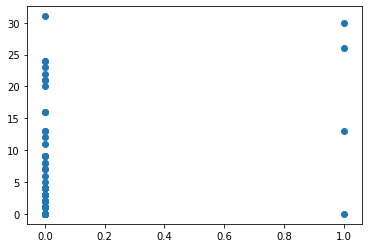

In [56]:
import matplotlib as mp
import matplotlib.pyplot as plt

plt.scatter(venues_grouped['Category_Train Station'],venues_grouped['Category_Restaurant'])
plt.show()

We plot hotel vs restaurant.

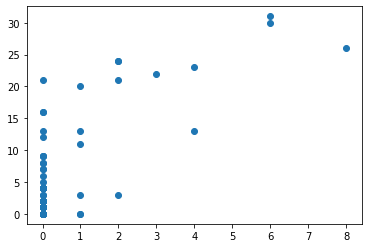

In [57]:
plt.scatter(venues_grouped['Category_Hotel'],venues_grouped['Category_Restaurant'])
plt.show()

We linear regress on top 25 neighborhoods with restaurants and later use the model to predict the other neighborhoods.

In [46]:
venues_top25 = venues_grouped.sort_values(by='Category_Restaurant', ascending=False).head(25)
y = venues_top25['Category_Restaurant']
X = venues_top25.drop(['Neighborhood','Category_Restaurant'],axis=1)
from sklearn.linear_model import Ridge
reg = Ridge(alpha=1.0)
reg.fit(X,y)
reg.score(X,y)


0.9995995564111885

In [47]:
X_total = venues_grouped.drop(['Neighborhood', 'Category_Restaurant'], axis=1)
y_total = reg.predict(X_total)
venues_with_predict = venues_grouped.copy()
venues_with_predict['Predict'] = y_total
cols = venues_with_predict.columns.tolist()
cols.remove('Predict')
cols.insert(0,'Predict')
cols.remove("Category_Restaurant")
cols.insert(0,'Category_Restaurant')
venues_with_predict = venues_with_predict[cols]
np.where((venues_with_predict['Predict'] > 10) & (venues_with_predict['Category_Restaurant'] < 7),venues_with_predict['Neighborhood'],None)

array([None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, 'Christie', None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None,
       'Regent Park, Harbourfront', None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None], dtype=object)

In [49]:
venues_grouped[venues_grouped['Category_Train Station'] > 0]

,Neighborhood,Category_Accessories Store,Category_Airport,Category_Airport Food Court,Category_Airport Gate,Category_Airport Lounge,Category_Airport Service,Category_Airport Terminal,Category_Antique Shop,Category_Aquarium,...,Category_Thrift / Vintage Store,Category_Toy / Game Store,Category_Trail,Category_Train Station,Category_Video Game Store,Category_Warehouse Store,Category_Wine Bar,Category_Wings Joint,Category_Women's Store,Category_Yoga Studio
29,"First Canadian Place, Underground city",0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
35,"Harbourfront East, Union Station, Toronto Islands",0,0,0,0,0,0,0,0,5,...,0,0,0,1,0,0,1,0,0,0
42,"Kennedy Park, Ionview, East Birchmount Park",0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
83,"Toronto Dominion Centre, Design Exchange",0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [51]:
venues_grouped[venues_grouped['Category_Hotel'] > 3]

,Neighborhood,Category_Accessories Store,Category_Airport,Category_Airport Food Court,Category_Airport Gate,Category_Airport Lounge,Category_Airport Service,Category_Airport Terminal,Category_Antique Shop,Category_Aquarium,...,Category_Thrift / Vintage Store,Category_Toy / Game Store,Category_Trail,Category_Train Station,Category_Video Game Store,Category_Warehouse Store,Category_Wine Bar,Category_Wings Joint,Category_Women's Store,Category_Yoga Studio
18,"Commerce Court, Victoria Hotel",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
29,"First Canadian Place, Underground city",0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
35,"Harbourfront East, Union Station, Toronto Islands",0,0,0,0,0,0,0,0,5,...,0,0,0,1,0,0,1,0,0,0
64,"Richmond, Adelaide, King",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83,"Toronto Dominion Centre, Design Exchange",0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


We will cluster neighborhood's by their scaled counts of venue, except for restaurants.

In [64]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
km = KMeans(n_clusters = 5)
X_cluster = venues_grouped.drop(['Neighborhood', 'Category_Restaurant'], axis=1)
X_scaled = StandardScaler().fit_transform(X_cluster)
km.fit(X_scaled)
X_scaled=pd.DataFrame(X_scaled)
X_scaled.columns = X_cluster.columns
X_scaled['Neighborhood'] = venues_grouped['Neighborhood']
X_scaled['Cluster'] = km.labels_
X_scaled['Category_Restaurant'] = venues_grouped['Category_Restaurant']
X_scaled = pd.merge(X_scaled, df_result, on='Neighborhood')
X_scaled.sort_values(by='Category_Restaurant', ascending=False).head(25)


,Category_Accessories Store,Category_Airport,Category_Airport Food Court,Category_Airport Gate,Category_Airport Lounge,Category_Airport Service,Category_Airport Terminal,Category_Antique Shop,Category_Aquarium,Category_Art Gallery,...,Category_Wings Joint,Category_Women's Store,Category_Yoga Studio,Neighborhood,Cluster,Category_Restaurant,PostalCode,Borough,Latitude,Longitude
18,-0.145865,-0.145865,-0.102598,-0.102598,-0.102598,-0.102598,-0.102598,-0.179605,-0.102598,2.240069,...,-0.102598,-0.155719,-0.364645,"Commerce Court, Victoria Hotel",4,31,M5L,Downtown Toronto,43.648198,-79.379817
33,-0.145865,-0.145865,-0.102598,-0.102598,-0.102598,-0.102598,-0.102598,-0.179605,-0.102598,2.240069,...,-0.102598,-0.155719,-0.364645,"First Canadian Place, Underground city",4,30,M5X,Downtown Toronto,43.648429,-79.382280
87,-0.145865,-0.145865,-0.102598,-0.102598,-0.102598,-0.102598,-0.102598,-0.179605,-0.102598,2.240069,...,-0.102598,-0.155719,-0.364645,"Toronto Dominion Centre, Design Exchange",4,26,M5K,Downtown Toronto,43.647177,-79.381576
76,-0.145865,-0.145865,-0.102598,-0.102598,-0.102598,-0.102598,-0.102598,-0.179605,-0.102598,2.240069,...,-0.102598,-0.155719,-0.364645,St. James Town,4,24,M5C,Downtown Toronto,43.651494,-79.375418
15,-0.145865,-0.145865,-0.102598,-0.102598,-0.102598,-0.102598,-0.102598,-0.179605,-0.102598,-0.382451,...,-0.102598,-0.155719,5.020885,Church and Wellesley,2,24,M4Y,Downtown Toronto,43.665860,-79.383160
68,-0.145865,-0.145865,-0.102598,-0.102598,-0.102598,-0.102598,-0.102598,-0.179605,-0.102598,2.240069,...,-0.102598,-0.155719,-0.364645,"Richmond, Adelaide, King",4,23,M5H,Downtown Toronto,43.650571,-79.384568
79,-0.145865,-0.145865,-0.102598,-0.102598,-0.102598,-0.102598,-0.102598,5.567764,-0.102598,4.862589,...,-0.102598,-0.155719,2.328120,Stn A PO Boxes,4,22,M5W,Downtown Toronto,43.646435,-79.374846
47,-0.145865,-0.145865,-0.102598,-0.102598,-0.102598,-0.102598,-0.102598,-0.179605,-0.102598,-0.382451,...,-0.102598,-0.155719,-0.364645,"Kensington Market, Chinatown, Grange Park",0,21,M5T,Downtown Toronto,43.653206,-79.400049
35,-0.145865,-0.145865,-0.102598,-0.102598,-0.102598,-0.102598,-0.102598,-0.179605,-0.102598,2.240069,...,-0.102598,-0.155719,-0.364645,"Garden District, Ryerson",3,21,M5B,Downtown Toronto,43.657162,-79.378937
13,-0.145865,-0.145865,-0.102598,-0.102598,-0.102598,-0.102598,-0.102598,-0.179605,-0.102598,-0.382451,...,-0.102598,-0.155719,2.328120,Central Bay Street,0,20,M5G,Downtown Toronto,43.657952,-79.387383


In [66]:
neigh3 = X_scaled[X_scaled['Cluster'] == 4]
neigh3

,Category_Accessories Store,Category_Airport,Category_Airport Food Court,Category_Airport Gate,Category_Airport Lounge,Category_Airport Service,Category_Airport Terminal,Category_Antique Shop,Category_Aquarium,Category_Art Gallery,...,Category_Wings Joint,Category_Women's Store,Category_Yoga Studio,Neighborhood,Cluster,Category_Restaurant,PostalCode,Borough,Latitude,Longitude
5,-0.145865,-0.145865,-0.102598,-0.102598,-0.102598,-0.102598,-0.102598,-0.179605,-0.102598,2.240069,...,-0.102598,-0.155719,-0.364645,Berczy Park,4,13,M5E,Downtown Toronto,43.644771,-79.373306
18,-0.145865,-0.145865,-0.102598,-0.102598,-0.102598,-0.102598,-0.102598,-0.179605,-0.102598,2.240069,...,-0.102598,-0.155719,-0.364645,"Commerce Court, Victoria Hotel",4,31,M5L,Downtown Toronto,43.648198,-79.379817
33,-0.145865,-0.145865,-0.102598,-0.102598,-0.102598,-0.102598,-0.102598,-0.179605,-0.102598,2.240069,...,-0.102598,-0.155719,-0.364645,"First Canadian Place, Underground city",4,30,M5X,Downtown Toronto,43.648429,-79.382280
68,-0.145865,-0.145865,-0.102598,-0.102598,-0.102598,-0.102598,-0.102598,-0.179605,-0.102598,2.240069,...,-0.102598,-0.155719,-0.364645,"Richmond, Adelaide, King",4,23,M5H,Downtown Toronto,43.650571,-79.384568
76,-0.145865,-0.145865,-0.102598,-0.102598,-0.102598,-0.102598,-0.102598,-0.179605,-0.102598,2.240069,...,-0.102598,-0.155719,-0.364645,St. James Town,4,24,M5C,Downtown Toronto,43.651494,-79.375418
79,-0.145865,-0.145865,-0.102598,-0.102598,-0.102598,-0.102598,-0.102598,5.567764,-0.102598,4.862589,...,-0.102598,-0.155719,2.328120,Stn A PO Boxes,4,22,M5W,Downtown Toronto,43.646435,-79.374846
87,-0.145865,-0.145865,-0.102598,-0.102598,-0.102598,-0.102598,-0.102598,-0.179605,-0.102598,2.240069,...,-0.102598,-0.155719,-0.364645,"Toronto Dominion Centre, Design Exchange",4,26,M5K,Downtown Toronto,43.647177,-79.381576


In [71]:
import matplotlib as mp
import folium

tor_lat=43.6532
tor_long=-79.3832
map_tor = folium.Map(location=[tor_lat,tor_long],zoom_start=11)
colors_array = mp.cm.rainbow(np.linspace(0,1,5))
rainbow = [mp.colors.rgb2hex(i) for i in colors_array]
for lat, long, neighborhood, cluster in zip(X_scaled['Latitude'], X_scaled['Longitude'], X_scaled['Neighborhood'], X_scaled['Cluster']):
    label = folium.Popup(str(neighborhood) + ' Cluster ' + str(cluster),parse_html=True)
    folium.CircleMarker(
        [lat,long],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7
    ).add_to(map_tor)
map_tor